In [1]:
import zipfile
import os
import pandas as pd

In [2]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df = df[['data_base', 'carteira_ativa']] 
            df = df.groupby(['data_base'])['carteira_ativa'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [3]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [18]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   data_base       135 non-null    datetime64[ns]
 1   carteira_ativa  135 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.2 KB


In [34]:
df_total['data_base'] = df_total['data_base'].dt.strftime('%Y-%m')

In [35]:
df_total.head(5)

,data_base,carteira_ativa
0,2012-06,2.059095e+12
1,2012-12,2.278845e+12
2,2012-07,2.113076e+12
3,2012-11,2.230830e+12
4,2012-10,2.198128e+12


In [36]:
# Importando a série do IPCA mensal (a)
#importa a bibliotaca
import requests

#define a url a ser usada
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json'
# fazendo a requisição à url e trazendo em formato json
inflacao_mensal = requests.get(url).json() 
#response é o nome da 'variável'. Pode ser qualquer outro nome

# visualizando os primeiros elementos da base
inflacao_mensal[500:505]

[{'data': '01/09/2021', 'valor': '1.16'},
 {'data': '01/10/2021', 'valor': '1.25'},
 {'data': '01/11/2021', 'valor': '0.95'},
 {'data': '01/12/2021', 'valor': '0.73'},
 {'data': '01/01/2022', 'valor': '0.54'}]

In [37]:
inflacao_df = pd.DataFrame(inflacao_mensal)

In [38]:
inflacao_df['data'] = pd.to_datetime(inflacao_df['data'], format = "%d/%m/%Y")

In [39]:
inflacao_df['data'] = inflacao_df['data'].dt.strftime('%Y-%m')

In [40]:
inflacao_df.head(5)

,data,valor
0,1980-01,6.62
1,1980-02,4.62
2,1980-03,6.04
3,1980-04,5.29
4,1980-05,5.70


In [54]:
df_inflacao_divida = pd.merge(inflacao_df,
                              df_total,
                              left_on="data",
                              right_on="data_base",
                              how = "inner")

In [55]:
df_inflacao_divida = df_inflacao_divida.drop(columns=['data'])

In [57]:
df_inflacao_divida = df_inflacao_divida.rename(columns={'valor': 'inflacao'})

In [73]:
df_inflacao_divida['inflacao'] = df_inflacao_divida['inflacao'].astype("float64")

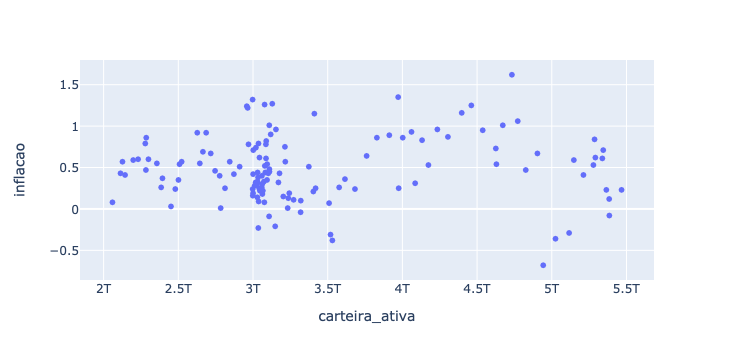

In [77]:
import plotly.express as px
fig = px.scatter(df_inflacao_divida, x="carteira_ativa", y="inflacao")
fig.show()

In [78]:
df_inflacao_divida.to_csv("estudo_inflacao.csv", index = False)